In [113]:
# Install google earth engine python API
# https://developers.google.com/earth-engine/python_install_manual
%pip install earthengine-api --upgrade pandas geopandas > /dev/null

Note: you may need to restart the kernel to use updated packages.


In [114]:
# Get a bounds of the Sviatohirsk city from OpenStreetMap API
# https://wiki.openstreetmap.org/wiki/Overpass_API
import requests


response = requests.get('https://overpass-api.de/api/interpreter?data=[out:json];%20area[name=%22%D0%A1%D0%B2%D1%8F%D1%82%D0%BE%D0%B3%D1%96%D1%80%D1%81%D1%8C%D0%BA%22]%20-%3E%20.a;%20(%20relation(area.a)[admin_level];%20);%20out%20geom;')
data = response.json()
bounds = data['elements'][0]['bounds']

offset = 0.01
# Make a geojson file with bounds as a polygon
geoJSON = {
    "type": "FeatureCollection",
    "features": [
        {
            "type": "Feature",
            "properties": {},
            "geometry":
            {
                "type": "Polygon",
                "coordinates": [
                    [
                        [bounds['minlon'] - offset, bounds['minlat'] - offset],
                        [bounds['minlon'] - offset, bounds['maxlat'] + offset],
                        [bounds['maxlon'] + offset, bounds['maxlat'] + offset],
                        [bounds['maxlon'] + offset, bounds['minlat'] - offset],
                        [bounds['minlon'] - offset, bounds['minlat'] - offset]
                    ]
                ]
            }
        }
    ]
}

bounds

{'minlat': 48.871914,
 'minlon': 37.294625,
 'maxlat': 49.0618144,
 'maxlon': 37.6970164}

In [115]:
# Plot the bounds on the map with folium
# https://python-visualization.github.io/folium/
import folium
import json

buffer_offset_x = -0.197
buffer_offset_y = -0.092
geoJSON_buffered = {
    "type": "FeatureCollection",
    "features": [
        {
            "type": "Feature",
            "properties": {},
            "geometry":
            {
                "type": "Polygon",
                "coordinates": [
                    [
                        [bounds['minlon'] - buffer_offset_x, bounds['minlat'] - buffer_offset_y],
                        [bounds['minlon'] - buffer_offset_x, bounds['maxlat'] + buffer_offset_y],
                        [bounds['maxlon'] + buffer_offset_x, bounds['maxlat'] + buffer_offset_y],
                        [bounds['maxlon'] + buffer_offset_x, bounds['minlat'] - buffer_offset_y],
                        [bounds['minlon'] - buffer_offset_x, bounds['minlat'] - buffer_offset_y]
                    ]
                ]
            }
        }
    ]
}

mp = folium.Map(location=[48.9, 37.5], zoom_start=11)
folium.GeoJson(json.dumps(geoJSON)).add_to(mp)
folium.GeoJson(json.dumps(geoJSON_buffered)).add_to(mp)
mp

In [116]:
import ee
import pandas as pd
import geopandas as gpd
ee.Authenticate()
ee.Initialize()

In [117]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, gamma, f, chi2
import IPython.display as disp
%matplotlib inline

In [118]:
# Define a method for displaying Earth Engine image tiles to folium map.
def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
    tiles = map_id_dict['tile_fetcher'].url_format,
    attr = 'Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    name = name,
    overlay = True,
    control = True
  ).add_to(self)

# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

In [119]:
aoi = ee.Geometry.Polygon(geoJSON['features'][0]['geometry']['coordinates'])
aoi_sub = ee.Geometry.Polygon(geoJSON_buffered['features'][0]['geometry']['coordinates'])

In [120]:
# Define the time range
start_date = '2022-02-1'
# end_date = '2022-02-24'
end_date = '2022-09-21'

# Create an ImageCollection for the given time range and AOI
ffa_collection = (ee.ImageCollection('COPERNICUS/S1_GRD')
              .filterBounds(aoi)
              .filterDate(ee.Date(start_date), ee.Date(end_date))
              .filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))
              .filter(ee.Filter.eq('relativeOrbitNumber_start', 43))
              .sort('system:time_start'))

ffa_fl_collection = (ee.ImageCollection('COPERNICUS/S1_GRD_FLOAT')
              .filterBounds(aoi)
              .filterDate(ee.Date(start_date), ee.Date(end_date))
              .filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))
              .filter(ee.Filter.eq('relativeOrbitNumber_start', 43))
              .sort('system:time_start'))

ffa_db = ee.Image(ffa_collection.filterDate(ee.Date('2022-02-16'), ee.Date('2022-02-17')).mosaic().clip(aoi))


In [121]:
location = aoi.centroid().coordinates().getInfo()[::-1]

# Make an RGB color composite image (VV,VH,VV/VH).
rgb = ee.Image.rgb(ffa_db.select('VV'),
                   ffa_db.select('VH'),
                   ffa_db.select('VV').divide(ffa_db.select('VH')))

# Create the map object.
mp = folium.Map(location=location, zoom_start=11)

# Add the S1 rgb composite to the map object.
mp.add_ee_layer(rgb, {'min': [-20, -20, 0], 'max': [0, 0, 2]}, 'FFA')
folium.GeoJson(json.dumps(geoJSON)).add_to(mp)
# Add a layer control panel to the map.
mp.add_child(folium.LayerControl())

# Display the map.
display(mp)

In [122]:
import time
# Show relativeOrbitNumber_start for the first image in the collection
print(ffa_fl_collection.first().get('relativeOrbitNumber_start').getInfo())
# Show orbitProperties_pass for the first image in the collection
print(ffa_fl_collection.first().get('orbitProperties_pass').getInfo())
# Getting all the dates in the collection
acq_times = ffa_fl_collection.aggregate_array('system:time_start').getInfo()
[time.strftime('%x', time.gmtime(acq_time/1000)) for acq_time in acq_times]

43
ASCENDING


['02/04/22',
 '02/16/22',
 '02/28/22',
 '03/12/22',
 '03/24/22',
 '04/05/22',
 '04/17/22',
 '04/29/22',
 '05/11/22',
 '05/23/22',
 '06/04/22',
 '06/16/22',
 '06/28/22',
 '07/10/22',
 '07/22/22',
 '08/03/22',
 '08/15/22',
 '08/27/22',
 '09/08/22',
 '09/20/22']

Mean:  None
Variance:  None
Hist:  [[0, 0], [0.01, 0], [0.02, 0], [0.03, 0], [0.04, 0], [0.05, 0], [0.06, 0], [0.07, 0], [0.08, 0], [0.09, 0], [0.1, 149], [0.11, 0], [0.12, 212], [0.13, 4], [0.14, 297], [0.15, 417], [0.16, 4], [0.17, 94], [0.18, 355], [0.19, 478], [0.2, 534], [0.21, 667], [0.22, 632], [0.23, 874], [0.24, 1042.3764705882354], [0.25, 1463], [0.26, 713], [0.27, 1185.3764705882354], [0.28, 1833], [0.29, 1085.3529411764707], [0.3, 1979.0666666666673], [0.31, 2107.58431372549], [0.32, 1697], [0.33, 2442.9176470588227], [0.34, 1956], [0.35000000000000003, 2007.3764705882354], [0.36, 3657], [0.37, 3216.9607843137246], [0.38, 3184.5843137254906], [0.39, 2417.5843137254906], [0.4, 4277.584313725491], [0.41000000000000003, 3983.3764705882354], [0.42, 3928.89411764706], [0.43, 3500.313725490197], [0.44, 3232.9215686274524], [0.45, 4532.1058823529365], [0.46, 4137.376470588235], [0.47000000000000003, 4475.168627450981], [0.48, 5231.705882352939], [0.49, 3201.376470588236], [0.5, 44

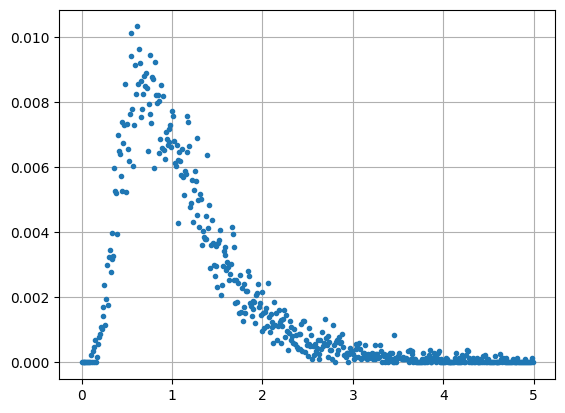

In [123]:
im1 = ee.Image(ffa_fl_collection.filterDate(ee.Date('2022-02-16'), ee.Date('2022-02-17')).mosaic().clip(aoi))
im2 = ee.Image(ffa_fl_collection.filterDate(ee.Date('2022-09-20'), ee.Date('2022-09-21')).mosaic().clip(aoi))
ratio = im1.divide(im2)
# print(ratio.getInfo())
hist = ratio.reduceRegion(
  ee.Reducer.fixedHistogram(0, 5, 500), aoi_sub,
    scale=1,  # specify an appropriate scale for your data
    maxPixels=1e9,
    bestEffort=True
  ).get('VV').getInfo()
mean = ratio.reduceRegion(ee.Reducer.mean(), aoi_sub).get('VV').getInfo()
variance = ratio.reduceRegion(ee.Reducer.variance(), aoi_sub).get('VV').getInfo()
print('Mean: ', mean)
print('Variance: ', variance)
print('Hist: ', hist)
a = np.array(hist)
x = a[:, 0]
y = a[:, 1] / np.sum(a[:, 1])
plt.grid()
plt.plot(x, y, '.')
plt.show()


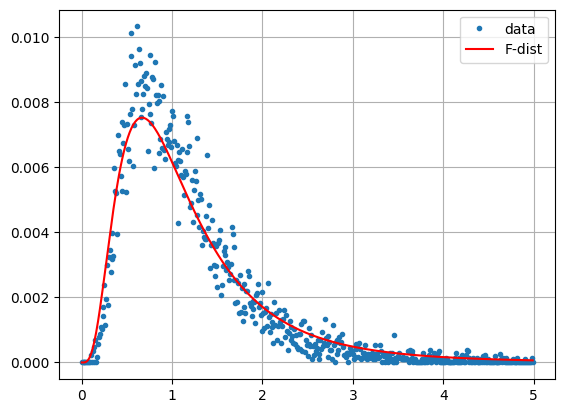

In [124]:
m = 5
plt.grid()
plt.plot(x, y, '.', label='data')
plt.plot(x, f.pdf(x, 2*m, 2*m) / 100, '-r', label='F-dist')
plt.legend()
plt.show()

In [125]:
print(mean, m/(m-1))
print(variance, m*(2*m-1)/(m-1)**2/(m-2))

None 1.25
None 0.9375


In [126]:
im1 = ee.Image(ffa_fl_collection.filterDate(ee.Date('2022-02-16'), ee.Date('2022-02-17')).mosaic().select('VV').clip(aoi))
im2 = ee.Image(ffa_fl_collection.filterDate(ee.Date('2022-09-20'), ee.Date('2022-09-21')).mosaic().select('VV').clip(aoi))
ratio = im1.divide(im2)

location = aoi.centroid().coordinates().getInfo()[::-1]
mp = folium.Map(location=location, zoom_start=11)
mp.add_ee_layer(ratio,
                {'min': 0, 'max': 20, 
                 'palette': ['black', 'white']
                 }, 'Ratio')
mp.add_child(folium.LayerControl())

display(mp)

In [127]:
# Decision threshold alpha/2:
dt = f.ppf(0.0005, 2*m, 2*m)

# LRT statistics.
q1 = im1.divide(im2)
q2 = im2.divide(im1)


# Change map with 0 = no change, 1 = decrease, 2 = increase in intensity.
c_map = im1.multiply(0).where(q2.lt(dt), 1)
c_map = c_map.where(q1.lt(dt), 2)

# Mask no-change pixels.
c_map = c_map.updateMask(c_map.gt(0))

# Display map with red for increase and blue for decrease in intensity.
location = aoi.centroid().coordinates().getInfo()[::-1]
mp = folium.Map(
    location=location, tiles='cartodb positron',
    zoom_start=11)
folium.TileLayer('OpenStreetMap').add_to(mp)
mp.add_ee_layer(ratio,
                {'min': 0, 'max': 20, 
                 'palette': ['black', 'white']
                 }, 'Ratio')
mp.add_ee_layer(c_map,
                {'min': 0, 'max': 2, 
                 'palette': ['black', 'blue', 'red']
                 },
                'Change Map')
mp.add_child(folium.LayerControl())

display(mp)

In [128]:
def det(im):
  return im.expression('b(0) * b(1)')

# Number of looks.
m = 5

im1 = ee.Image(ffa_fl_collection.filterDate(ee.Date('2022-02-16'), ee.Date('2022-02-17')).mosaic().select('VV', 'VH').clip(aoi))
im2 = ee.Image(ffa_fl_collection.filterDate(ee.Date('2022-09-20'), ee.Date('2022-09-21')).mosaic().select('VV', 'VH').clip(aoi))

m2logQ = det(im1).log().add(det(im2).log()).subtract(
    det(im1.add(im2)).log().multiply(2)).add(4*np.log(2)).multiply(-2*m)

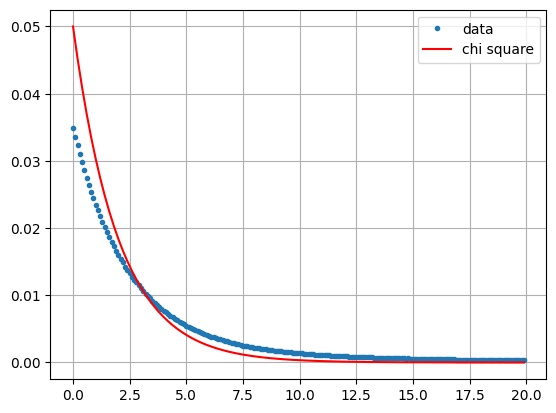

In [129]:
hist = m2logQ.reduceRegion(
    ee.Reducer.fixedHistogram(0, 20, 200), aoi,
    scale=1,  # specify an appropriate scale for your data
    maxPixels=1e9,
    bestEffort=True
).get('VV').getInfo()
a = np.array(hist)
x = a[:, 0]
y = a[:, 1] / np.sum(a[:, 1])
plt.plot(x, y, '.', label='data')
plt.plot(x, chi2.pdf(x, 2)/10, '-r', label='chi square')
plt.legend()
plt.grid()
plt.show()

In [130]:
im1 = ee.Image(ffa_fl_collection.filterDate(ee.Date('2022-02-16'), ee.Date('2022-02-17')).mosaic().clip(aoi))
im2 = ee.Image(ffa_fl_collection.filterDate(ee.Date('2022-09-20'), ee.Date('2022-09-21')).mosaic().clip(aoi))
def chi2cdf(chi2, df):
  ''' Chi square cumulative distribution function for df degrees of freedom
      using the built-in incomplete gamma function gammainc() '''
  return ee.Image(chi2.divide(2)).gammainc(ee.Number(df).divide(2))

# The observed test statistic image -2logq.
m2logq = det(im1).log().add(det(im2).log()).subtract(
    det(im1.add(im2)).log().multiply(2)).add(4*np.log(2)).multiply(-2*m)

# The P value image prob(m2logQ > m2logq) = 1 - prob(m2logQ < m2logq).
p_value = ee.Image.constant(1).subtract(chi2cdf(m2logq, 2))

# Project onto map.
location = aoi.centroid().coordinates().getInfo()[::-1]
mp = folium.Map(location=location, zoom_start=12)
mp.add_ee_layer(p_value,
                {'min': 0,'max': 1, 'palette': ['black', 'white']}, 'P-value')
mp.add_child(folium.LayerControl())